# Multi-class Substructure Classification

<u>Evaluation Metrics</u>: ROC curve (Receiver Operating Characteristic curve) and AUC score (Area Under the ROC Curve).

<u>Approach Used</u>: Train and evaluate the performance of different CNNs, ViTs, and Ensembles. Combine (average) the predictions of all the models to provide the best results.

# 1. Imports

In [1]:
import os
import numpy as np
import pandas as pd
from pandas.core.common import flatten
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import platform
from tqdm import tqdm
import random
import glob
import copy
from dataclasses import dataclass
import time
from collections import Counter
from collections import defaultdict
import gc

import sklearn
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, roc_auc_score

import albumentations as A
# from albumentations.pytorch import ToTensorV2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.nn.functional as nnf

import timm
import cv2

import warnings
warnings.filterwarnings("ignore")

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/home/harsh/anaconda3/envs/pytorch-cuda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Check for GPU availability

In [2]:
!nvidia-smi

Fri Mar 29 17:00:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.60.01              Driver Version: 551.76         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4080        On  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P0             50W /  320W |    8571MiB /  16376MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Define a `CONFIG` class containing different hyperparameters for our models, set a common random seed and use the `DEVICE` (GPU) to train the models.

In [25]:
@dataclass
class CONFIG:
    TRAIN_PATH = "/kaggle/input/gsoc-deep-lense-task-1/dataset/train"
    VAL_PATH = "/kaggle/input/gsoc-deep-lense-task-1/dataset/val"
    MODEL_NAMES = ['densenet161', 'mobilevitv2_150', 'mobilevitv2_150_384_in22ft1k']
    BATCH_SIZE = 16
    LEARNING_RATE = 1e-4
    DROPOUT = 0.3
    EPOCHS = 10

def set_seed(seed):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    
def get_device():
    global DEVICE
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
        DEVICE = torch.device("cuda:0")
    else:
        print("\n[INFO] GPU not found. Using CPU: {}\n".format(platform.processor()))
        DEVICE = torch.device("cpu")
    
RANDOM_SEED = 42
set_seed(RANDOM_SEED)
get_device()

[INFO] Using GPU: NVIDIA GeForce RTX 4080



Get file paths for training and validation sets

In [4]:
# train_image_paths = []
# val_image_paths = []
# classes = []

# for train_data_path in glob.glob(CONFIG.TRAIN_PATH + "/*"):
#     classes.append(train_data_path.split("/")[-1])
#     train_image_paths.append(glob.glob(train_data_path + "/*"))
    
# for val_data_path in glob.glob(CONFIG.VAL_PATH + "/*"):
#     val_image_paths.append(glob.glob(val_data_path + "/*"))
    
# # print(train_image_paths)
# # print(classes)

# train_image_paths = list(flatten(train_image_paths))
# val_image_paths = list(flatten(val_image_paths))


# # print(f"Train Image Path: {train_image_paths[0].split('/')[-2]}")
# # print(f"Class: {classes[0]}")

# print(f"Train Size: {len(train_image_paths)}\nVal Size: {len(val_image_paths)}")

Map indices to classes and vice-versa

In [5]:
# idx_to_class = {i: j for i, j in enumerate(classes)}
# class_to_idx = {value: key for key, value in idx_to_class.items()}

# print(f"Index to class dictionary: {idx_to_class}")
# print(f"Class to index dictionary: {class_to_idx}")

# 2. Creating the Dataset

Create a custom dataset class `GSoCDeepLensePrivateDatasetTask1` for creating train and valid sets

In [6]:
# class GSoCDeepLensePrivateDatasetTask1(Dataset):
    
#     def __init__(self, image_paths, transform=False):
#         self.image_paths = image_paths
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.image_paths)
    
#     def __getitem__(self, idx):
#         image_filepath = self.image_paths[idx]
#         image = np.load(image_filepath)
        
#         if(self.transform is not False):
#             image = self.transform(image=image)["image"]
        
#         label = image_filepath.split("/")[-2]
#         label = class_to_idx[label]
            
#         return image, label

# train_dataset = GSoCDeepLensePrivateDatasetTask1(image_paths=train_image_paths, transform=False)
# val_dataset = GSoCDeepLensePrivateDatasetTask1(image_paths=val_image_paths, transform=False)

# 3. Visualizing Images

Taking a look at the images present in the train and valid sets respectively

In [7]:
# def visualize_images(dataset_input, dataset_type, samples, cols):
    
#     dataset_len = len(dataset_input)
#     dataset = dataset_input
    
#     rows = samples // cols
    
#     fig, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12, 8))
#     fig.suptitle(f"========= Images for the {dataset_type.title()} set =========", y=0.9)
    
#     for i in range(samples):
#         idx = np.random.randint(0, dataset_len)
#         image, label = dataset[idx]
# #         image = np.expand_dim(image, axis=0)
#         image = image.swapaxes(0, 1)
#         image = image.swapaxes(1, 2)
#         ax.ravel()[i].imshow(image)
#         ax.ravel()[i].set_axis_off()
#         ax.ravel()[i].set_title(f"Index: {idx}, Label: {idx_to_class[label]}")
        
#     plt.tight_layout(rect=[0, 0.2, 0.99, 0.975], h_pad=2.1, pad=1.7)
#     plt.show()
    
# visualize_images(dataset_input=train_dataset, dataset_type="train", samples=10, cols=5)
# visualize_images(dataset_input=val_dataset, dataset_type="validation", samples=10, cols=5)

# 4. Creating Dataloaders

Creating train and valid dataloaders

In [8]:
# def make_data_loader(dataset, shuffle):
#     loader = DataLoader(dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=shuffle)
    
#     return loader

# train_loader = make_data_loader(dataset=train_dataset, shuffle=True)
# val_loader = make_data_loader(dataset=val_dataset, shuffle=False)

# LOADING DATA

Creating custom model classes that inherit from `nn.Module`

In [9]:
# no = np.load("../../00_data/original_data/no.npy")
# sphere = np.load("../../00_data/original_data/sphere.npy")
# vortex = np.load("../../00_data/original_data/vortex.npy")

train_no = np.load("../../00_data/augumented/augmented_no.npy")
train_sphere = np.load("../../00_data/augumented/augmented_sphere.npy")
train_vortex = np.load("../../00_data/augumented/augmented_vort.npy")

In [10]:
train_no = np.expand_dims(train_no, axis=-1)
train_sphere = np.expand_dims(train_sphere, axis=-1)
train_vortex = np.expand_dims(train_vortex, axis=-1)


In [11]:
val_no = np.load("../../00_data/validation_data/val_no.npy")
val_sphere = np.load("../../00_data/validation_data/val_sphere.npy")
val_vortex = np.load("../../00_data/validation_data/val_vortex.npy")


In [12]:
y_no = np.zeros(len(train_no))
y_sphere = np.ones(len(train_sphere))
y_vortex = np.full(len(train_vortex), 2)

In [13]:

val_y_no = np.zeros(len(val_no))
val_y_sphere = np.ones(len(val_sphere))
val_y_vortex = np.full(len(val_vortex), 2)

In [14]:

import torch
import torch.nn.functional as F


num_classes = 3

y_no = F.one_hot(torch.tensor(y_no, dtype=torch.int64), num_classes=num_classes)
y_sphere = F.one_hot(torch.tensor(y_sphere, dtype=torch.int64), num_classes=num_classes)
y_vortex= F.one_hot(torch.tensor(y_vortex, dtype=torch.int64), num_classes=num_classes)


In [15]:
val_y_no = F.one_hot(torch.tensor(val_y_no, dtype=torch.int64), num_classes=num_classes)
val_y_sphere = F.one_hot(torch.tensor(val_y_sphere, dtype=torch.int64), num_classes=num_classes)
val_y_vortex = F.one_hot(torch.tensor(val_y_vortex, dtype=torch.int64), num_classes=num_classes)


In [16]:
gc.collect()

77

In [17]:
x_train = np.concatenate([train_no, train_sphere, train_vortex], axis=0)
y_train = np.concatenate([y_no, y_sphere, y_vortex], axis=0)

In [18]:
x_val = np.concatenate([val_no, val_sphere, val_vortex], axis=0)
y_val = np.concatenate([val_y_no, val_y_sphere, val_y_vortex], axis=0)

In [19]:
del(train_no,train_sphere,train_vortex)
del(val_no,val_sphere,val_vortex)


gc.collect()


0

In [20]:
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)

# Permute the dimensions to [batch_size, channels, height, width]
x_train = x_train_tensor.permute(0, 3, 1, 2)
x_val = x_val_tensor.permute(0, 3, 1, 2)




In [21]:
x_train.shape

torch.Size([150000, 1, 150, 150])

In [22]:
# from sklearn.model_selection import train_test_split

# x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=RANDOM_SEED, stratify=y_data)

In [28]:
class TransferLearningModelOld(nn.Module):
    
    def __init__(self, n_classes):
        super(TransferLearningModelOld, self).__init__()
        self.transfer_learning_model = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.25),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.25),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)
        
        return x

class TransferLearningModelNew(nn.Module):
    
    def __init__(self, n_classes):
        super(TransferLearningModelNew, self).__init__()
        self.transfer_learning_model = timm.create_model(CONFIG.MODEL_NAMES[0], pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(2208 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.33),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.33),
            nn.Linear(64, n_classes)
        )
         
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
        x = x.view(-1, 2208 * 4 * 4)
        x = self.classifier(x)
        
        return x

class DenseNet264(nn.Module):
    
    def __init__(self, n_classes):
        super(DenseNet264, self).__init__()
        self.transfer_learning_model = timm.create_model("densenet264", pretrained=True, in_chans=1)
        
        for param in self.transfer_learning_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(1920 * 4 * 4, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=0.33),
            nn.Linear(1024, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=0.33),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.transfer_learning_model.forward_features(x)
#         print(x.shape)
        x = x.view(-1, 1920 * 4 * 4)
        x = self.classifier(x)
        
        return x
    
class MobileVitV2_150(nn.Module):
    
    def __init__(self, n_classes):
        
        super(MobileVitV2_150, self).__init__()
        
        self.vit_model = timm.create_model(CONFIG.MODEL_NAMES[2], pretrained=True, in_chans=1)
        
        for param in self.vit_model.parameters():
            param.requires_grad = True
            
        self.classifier = nn.Sequential(
            nn.Linear(768 * 6 * 6, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(p=CONFIG.DROPOUT),
            nn.Linear(64, n_classes)
        )
        
    def forward(self, x):
        x = self.vit_model.forward_features(x)
#         print(x.shape)
        x = x.reshape(-1, 768 * 6 * 6)
        x = self.classifier(x)
        
        return x

# (test performance of an ensemble)
class DenseNetEnsemble(nn.Module):
    
    def __init__(self, n_classes, modela, modelb):
        
        super(DenseNetEnsemble, self).__init__()
        
        self.modela = modela
        self.modelb = modelb
        
    def forward(self, x):
        outa = self.modela(x)
        outb = self.modelb(x)
        out = outa + outb
        x = out
        
        return x

Since the latest training example was that of an ensemble model we initialize `model` as an instance of the `DenseNetEnsemble` class

In [29]:
# model = MobileVitv2_150_384_in22ft1k(len(classes))
# model = model.to(DEVICE)

classes = ["no", "sphere", "vortex"]

# modela = TransferLearningModelNew(len(classes))
# modela = modela.to(DEVICE)

modelb = DenseNet264(len(classes))
modelb = modelb.to(DEVICE)

model = modelb

# model = DenseNetEnsemble(len(classes), modela, modelb)
# model = model.to(DEVICE)
# x = torch.randn(32,1,150,150).to(DEVICE)
# model(x).shape

RuntimeError: Unknown model (densenet264)

Trains the model for 1 epoch

In [39]:
def train_one_epoch(model, optimizer, data_loader, device):
    
    model.train()
    
    total = 0
    correct = 0
    train_accuracy = []
    train_loss = []
    
    for i, data in enumerate(tqdm(data_loader)):
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        y_pred = model(images.float())
        loss = criterion(y_pred, labels)
        
        _, predicted = torch.max(y_pred.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy = 100 * correct / total
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if(i % 10 == 0):
        #     print(f"Loss: {loss}, Accuracy: {accuracy}")
        
        train_accuracy.append(torch.tensor(accuracy))
        train_loss.append(torch.tensor(loss))
        
    return train_accuracy, train_loss

Tests the performance of the trained model

In [38]:
def test_model(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
        
            y_pred = model(images.float())
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss

Converts tensor-lists to numpy arrays and computes the mean value

In [40]:
def convert_tensor_list_to_single_mean_value(tensor_list):

    tensor_list = [tensor.detach().cpu().numpy() for tensor in tensor_list]
    
    return np.mean(tensor_list)

Criterion and optimizer used to train the model

In [41]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

# 5. Training the Model

Cell commented out to save GPU time

In [42]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from collections import defaultdict
import numpy as np

# Assuming x_train, y_train, x_val, and y_val are NumPy arrays
# Convert them to PyTorch tensors if they aren't already
# If y_train and y_val are NumPy arrays and one-hot encoded
y_train_labels = np.argmax(y_train, axis=1)
y_val_labels = np.argmax(y_val, axis=1)

# Convert them to PyTorch tensors
y_train_tensor = torch.tensor(y_train_labels, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_labels, dtype=torch.long)

# Then, everything else remains the same
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)

# Create TensorDatasets and DataLoaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False)



In [43]:
train_loader

In [44]:
# %%time

history = defaultdict(list)
best_accuracy = 0
model_name = "ensemble"

for epoch in range(CONFIG.EPOCHS):
    print(f"Epoch {epoch + 1} / {CONFIG.EPOCHS}")
    print('=' * 10)
    
    train_accuracy, train_loss = train_one_epoch(model=model, optimizer=optimizer, data_loader=train_loader, device=DEVICE)
    train_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=train_accuracy)
    train_loss = convert_tensor_list_to_single_mean_value(tensor_list=train_loss)
    print(f'Train loss: {train_loss}\nTrain accuracy: {train_accuracy}\n')
    
    val_accuracy, val_loss = test_model(model=model, data_loader=val_loader, device=DEVICE)
    val_accuracy = convert_tensor_list_to_single_mean_value(tensor_list=val_accuracy)
    val_loss = convert_tensor_list_to_single_mean_value(tensor_list=val_loss)
    print(f'Val loss: {val_loss}\nVal accuracy: {val_accuracy}\n')
    
    history['train_acc'].append(train_accuracy)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_accuracy)
    history['val_loss'].append(val_loss) 
    
    if(val_accuracy > best_accuracy):
        torch.save(model.state_dict(), 
                   f'{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.bin')
        best_accuracy = val_accuracy

Epoch 1 / 10


100%|██████████| 4688/4688 [05:35<00:00, 13.96it/s]


Train loss: 0.25798529386520386
Train accuracy: 90.06790161132812



100%|██████████| 235/235 [00:03<00:00, 66.07it/s]


Val loss: 0.20926448702812195
Val accuracy: 95.52152252197266

Epoch 2 / 10


100%|██████████| 4688/4688 [05:42<00:00, 13.70it/s]


Train loss: 0.1908077746629715
Train accuracy: 93.19293975830078



100%|██████████| 235/235 [00:03<00:00, 68.28it/s]


Val loss: 0.19337552785873413
Val accuracy: 96.19132995605469

Epoch 3 / 10


100%|██████████| 4688/4688 [05:41<00:00, 13.71it/s]


Train loss: 0.1591077744960785
Train accuracy: 94.6353759765625



100%|██████████| 235/235 [00:03<00:00, 68.87it/s]


Val loss: 0.15934446454048157
Val accuracy: 95.99308776855469

Epoch 4 / 10


100%|██████████| 4688/4688 [05:42<00:00, 13.70it/s]


Train loss: 0.13745099306106567
Train accuracy: 95.30917358398438



100%|██████████| 235/235 [00:03<00:00, 67.91it/s]


Val loss: 0.14808741211891174
Val accuracy: 96.50961303710938

Epoch 5 / 10


100%|██████████| 4688/4688 [05:38<00:00, 13.84it/s]


Train loss: 0.1210901066660881
Train accuracy: 95.98408508300781



100%|██████████| 235/235 [00:03<00:00, 68.68it/s]


Val loss: 0.14172814786434174
Val accuracy: 95.90254211425781

Epoch 6 / 10


100%|██████████| 4688/4688 [05:34<00:00, 14.00it/s]


Train loss: 0.10736416280269623
Train accuracy: 96.4769058227539



100%|██████████| 235/235 [00:03<00:00, 68.59it/s]


Val loss: 0.17007218301296234
Val accuracy: 96.38410186767578

Epoch 7 / 10


100%|██████████| 4688/4688 [05:36<00:00, 13.94it/s]


Train loss: 0.09692396968603134
Train accuracy: 96.84335327148438



100%|██████████| 235/235 [00:03<00:00, 68.24it/s]


Val loss: 0.14711348712444305
Val accuracy: 95.07441711425781

Epoch 8 / 10


100%|██████████| 4688/4688 [05:35<00:00, 13.98it/s]


Train loss: 0.08649846911430359
Train accuracy: 97.14102172851562



100%|██████████| 235/235 [00:03<00:00, 68.96it/s]


Val loss: 0.13467863202095032
Val accuracy: 96.81798553466797

Epoch 9 / 10


100%|██████████| 4688/4688 [05:36<00:00, 13.93it/s]


Train loss: 0.0780496746301651
Train accuracy: 97.52978515625



100%|██████████| 235/235 [00:03<00:00, 69.18it/s]


Val loss: 0.14419876039028168
Val accuracy: 96.59703826904297

Epoch 10 / 10


100%|██████████| 4688/4688 [05:34<00:00, 14.00it/s]


Train loss: 0.06976909190416336
Train accuracy: 97.8835220336914



100%|██████████| 235/235 [00:03<00:00, 69.14it/s]

Val loss: 0.15178994834423065
Val accuracy: 96.67733764648438



# 6. Visualizing Model Performance of a trained model


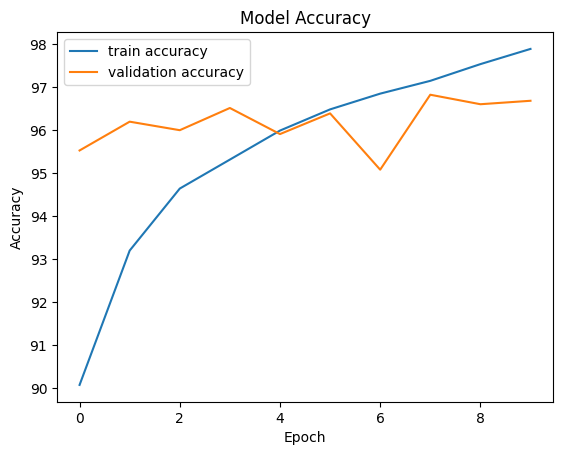

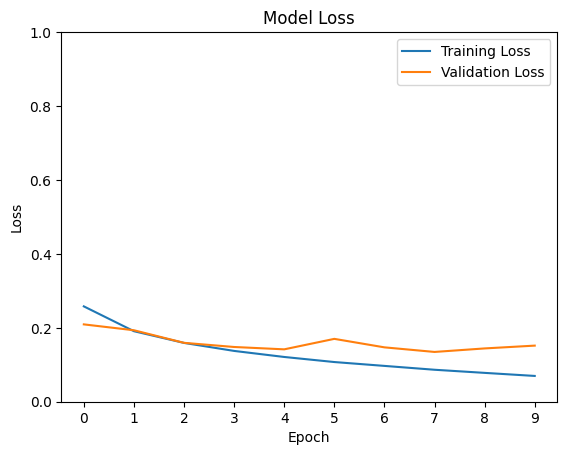

In [45]:
def generate_acc_loss_plots(history):
    
    ax = plt.figure().gca()
    plt.plot(history['train_acc'], label='train accuracy')
    plt.plot(history['val_acc'], label='validation accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    ax = plt.figure().gca()
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.ylim([0, 1])
    plt.show()
    
generate_acc_loss_plots(history)

Reduce memory usage by deleting all redundant variables

In [ ]:
# del model, train_loader, history
# gc.collect()

Loading all the previously trained models. In case evaluation is to be done for a single model, all the lines need to be commented out, except for the last 3. Otherwise, all the models trained will be loaded.

In [47]:
# model1 = TransferLearningModelOld(len(classes))
# model1 = model1.to(DEVICE)
# model1.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/densenet161_epochs_2_batchsize_64_lr_0.0001.bin'))

# model2 = TransferLearningModelOld(len(classes))
# model2 = model2.to(DEVICE)
# model2.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/densenet161_epochs_6_batchsize_64_lr_0.0001.bin'))

# model3 = TransferLearningModelNew(len(classes))
# model3 = model3.to(DEVICE)
# model3.load_state_dict(torch.load(f'/kaggle/input/gsoc-task-1-models/densenet161_epochs_15_batchsize_64_lr_0.0001.bin'))

# model4 = MobileVitV2_150(len(classes))
# model4 = model4.to(DEVICE)
# model4.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/mobilevitv2_150_epochs_15_batchsize_32_lr_0.0001.bin'))

model = DenseNet201(len(classes))
model = model.to(DEVICE)
model.load_state_dict(torch.load('densenet201_epochs_10_batchsize_32_lr_0.0001.bin'))

# model6 = DenseNetEnsemble(len(classes),
#                           TransferLearningModelNew(len(classes)).to(DEVICE),
#                           DenseNet201(len(classes)).to(DEVICE)
#                          )
# model6 = model6.to(DEVICE)
# model6.load_state_dict(torch.load('/kaggle/input/gsoc-task-1-models/ensemble_epochs_10_batchsize_32_lr_0.0001.bin'))

# model = DenseNetEnsemble(len(classes), modela, modelb)
# model = model.to(DEVICE)
# model.load_state_dict(torch.load(f'/kaggle/working/{model_name}_epochs_{CONFIG.EPOCHS}_batchsize_{CONFIG.BATCH_SIZE}_lr_{CONFIG.LEARNING_RATE}.bin'))

<All keys matched successfully>

# 7. Model Predictions

In [55]:
def get_model_predictions(model, data_loader, device):
    
    model.eval()
    
    total = 0
    correct = 0
    val_accuracy = []
    val_loss = []
    y_test_all = []
    y_pred_all = []
    y_pred_prob_all = []
    
    with torch.no_grad():
        for i, data in enumerate(tqdm(data_loader)):
            images, labels = data
            
            images = images.to(device)
            labels = labels.to(device)
            y_test_all.append(labels)
        
            y_pred = model(images.float())
#             print("y_pred:", y_pred, y_pred.shape)
            prob = nnf.softmax(y_pred, dim=1)
#             print("prob:", prob, prob.shape)
            loss = criterion(y_pred, labels)

            _, predicted = torch.max(y_pred.data, 1)
#             print("predicted", predicted, predicted.shape)
            y_pred_prob_all.append(prob)
            y_pred_all.append(predicted)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            accuracy = 100 * correct / total
            
            val_accuracy.append(torch.tensor(accuracy))
            val_loss.append(torch.tensor(loss))
                    
    return val_accuracy, val_loss, y_test_all, y_pred_all, y_pred_prob_all

# test_accuracy1, test_loss1, y_test1, y_pred1, y_pred_prob1 = get_model_predictions(model=model1, data_loader=val_loader, device=DEVICE)
# test_accuracy2, test_loss2, y_test2, y_pred2, y_pred_prob2 = get_model_predictions(model=model2, data_loader=val_loader, device=DEVICE)
# test_accuracy3, test_loss3, y_test3, y_pred3, y_pred_prob3 = get_model_predictions(model=model3, data_loader=val_loader, device=DEVICE)
# test_accuracy4, test_loss4, y_test4, y_pred4, y_pred_prob4 = get_model_predictions(model=model4, data_loader=val_loader, device=DEVICE)
# test_accuracy5, test_loss5, y_test5, y_pred5, y_pred_prob5 = get_model_predictions(model=model5, data_loader=val_loader, device=DEVICE)
# test_accuracy6, test_loss6, y_test6, y_pred6, y_pred_prob6 = get_model_predictions(model=model6, data_loader=val_loader, device=DEVICE)
test_accuracy, test_loss, y_test, y_pred, y_pred_prob = get_model_predictions(model=model, data_loader=val_loader, device=DEVICE)

100%|██████████| 235/235 [00:03<00:00, 63.31it/s]


Flattens the `y_test` and `y_pred` arrays

In [56]:
def get_flat_arrays(arrays):
    arrays = [tensor.detach().cpu().numpy() for tensor in arrays]
    arrays = np.concatenate(arrays)
    arrays = arrays.ravel()
    
    return arrays
    
# y_test1 = get_flat_arrays(arrays=y_test1)
# y_pred1 = get_flat_arrays(arrays=y_pred1)

# y_test2 = get_flat_arrays(arrays=y_test2)
# y_pred2 = get_flat_arrays(arrays=y_pred2)

# y_test3 = get_flat_arrays(arrays=y_test3)
# y_pred3 = get_flat_arrays(arrays=y_pred3)

# y_test4 = get_flat_arrays(arrays=y_test4)
# y_pred4 = get_flat_arrays(arrays=y_pred4)

# y_test5 = get_flat_arrays(arrays=y_test5)
# y_pred5 = get_flat_arrays(arrays=y_pred5)

# y_test6 = get_flat_arrays(arrays=y_test6)
# y_pred6 = get_flat_arrays(arrays=y_pred6)

y_test = get_flat_arrays(arrays=y_test)
y_pred = get_flat_arrays(arrays=y_pred)

# 8. Classification Reports and Confusion Matrices

Gives a better understanding about the performance of the models

========== For DenseNet201_Epochs_10 ==========

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2500
           1       0.97      0.91      0.94      2500
           2       0.97      0.96      0.97      2500

    accuracy                           0.95      7500
   macro avg       0.96      0.95      0.95      7500
weighted avg       0.96      0.95      0.95      7500



F1 Score: 0.954657729906558
Precision: 0.9555932246478829
Recall: 0.9548




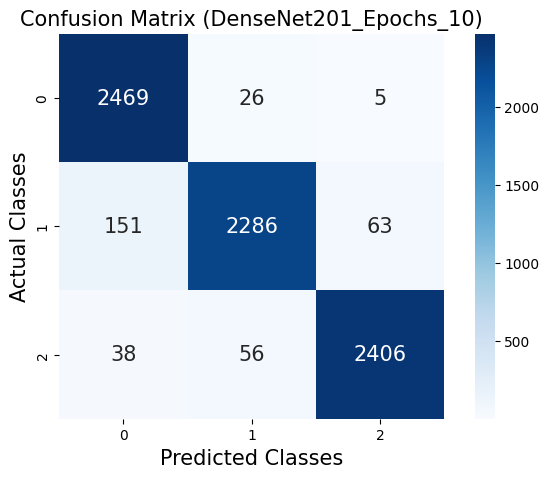

In [57]:
def get_model_classification_report_and_confusion_matrix(model_name, y_test, y_pred):
    
    print("=" * 10, f"For {model_name}", "=" * 10)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    print("\n")
    print(f"F1 Score: {f1_score(y_test, y_pred, average = 'weighted')}")
    print(f"Precision: {precision_score(y_test, y_pred, average = 'weighted')}")
    print(f"Recall: {recall_score(y_test, y_pred, average = 'weighted')}")
    print("\n")
    plt.figure(figsize = (8, 5))
    ax = plt.axes()
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, square = True, fmt = "d", cmap = "Blues", cbar = True, annot_kws={'size': 15})
    ax.xaxis.set_tick_params(labelsize = 10)
    ax.yaxis.set_tick_params(labelsize = 10)
    plt.title(f"Confusion Matrix ({model_name})", fontsize = 15)
    plt.ylabel("Actual Classes", fontsize = 15)
    plt.xlabel("Predicted Classes", fontsize = 15)
    plt.show()
    print("\n")
    
# get_model_classification_report_and_confusion_matrix("DenseNet161_Epochs_2", y_test1, y_pred1)
# get_model_classification_report_and_confusion_matrix("DenseNet161_Epochs_6", y_test2, y_pred2)
# get_model_classification_report_and_confusion_matrix("DenseNet161_Epochs_15", y_test3, y_pred3)
# get_model_classification_report_and_confusion_matrix("MobileVitV2_150_Epochs_15", y_test4, y_pred4)
# get_model_classification_report_and_confusion_matrix("DenseNet201_Epochs_15", y_test5, y_pred5)
# get_model_classification_report_and_confusion_matrix("Ensemble_DenseNet161_DenseNet201_Epochs_10", y_test6, y_pred6)
get_model_classification_report_and_confusion_matrix("DenseNet201_Epochs_10", y_test, y_pred)


One-hot encoding the arrays

In [58]:
def one_hot_encode_array(array, num_classes):
    
    return np.squeeze(np.eye(num_classes)[array.reshape(-1)])

# y_test1 = one_hot_encode_array(array=y_test1, num_classes=len(classes))
# y_pred1 = one_hot_encode_array(array=y_pred1, num_classes=len(classes))

# y_test2 = one_hot_encode_array(array=y_test2, num_classes=len(classes))
# y_pred2 = one_hot_encode_array(array=y_pred2, num_classes=len(classes))

# y_test3 = one_hot_encode_array(array=y_test3, num_classes=len(classes))
# y_pred3 = one_hot_encode_array(array=y_pred3, num_classes=len(classes))

# y_test4 = one_hot_encode_array(array=y_test4, num_classes=len(classes))
# y_pred4 = one_hot_encode_array(array=y_pred4, num_classes=len(classes))

# y_test5 = one_hot_encode_array(array=y_test5, num_classes=len(classes))
# y_pred5 = one_hot_encode_array(array=y_pred5, num_classes=len(classes))

# y_test6 = one_hot_encode_array(array=y_test6, num_classes=len(classes))
# y_pred6 = one_hot_encode_array(array=y_pred6, num_classes=len(classes))

y_test = one_hot_encode_array(array=y_test, num_classes=len(classes))
y_pred = one_hot_encode_array(array=y_pred, num_classes=len(classes))

Converting the `y_pred_prob` array into the required format.

In [61]:
def get_flattened_array(array):
    
    flattened_array = []
    
    for row in array:
        for col in row:
            flattened_array.append(col)
            
    return flattened_array

def get_required_array_format(array):
    
    array = get_flattened_array(array)
    array = [tensor.detach().cpu().numpy() for tensor in array]
    array = np.array(array)
    
    return array


# y_pred_prob1 = get_required_array_format(y_pred_prob1)
# y_pred_prob2 = get_required_array_format(y_pred_prob2)
# y_pred_prob3 = get_required_array_format(y_pred_prob3)
# y_pred_prob4 = get_required_array_format(y_pred_prob4)
# y_pred_prob5 = get_required_array_format(y_pred_prob5)
# y_pred_prob6 = get_required_array_format(y_pred_prob6)
y_pred_prob = get_required_array_format(y_pred_prob)

# 9. ROC-AUC Curves of the trained models

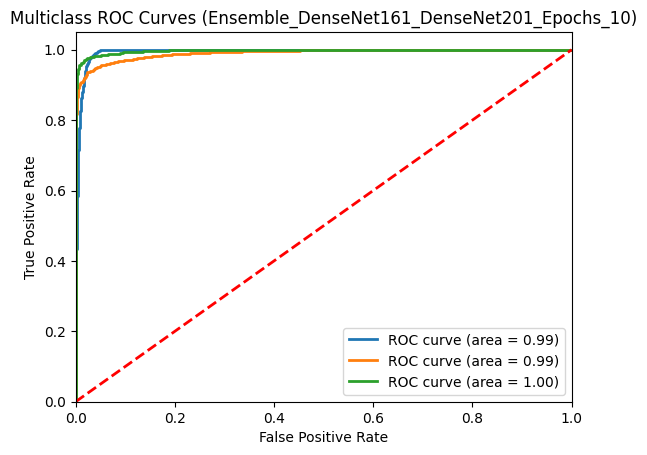

In [62]:
def plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, model_name):

    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = len(classes)

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_prob[:, i], )
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure()
    lw = 2
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], color='red', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multiclass ROC Curves ({model_name})')
    plt.legend(loc="lower right")
    plt.show()
    
# plot_auc_score_and_multiclass_roc_curves(y_test1, y_pred_prob1, "DenseNet161_Epochs_2")
# plot_auc_score_and_multiclass_roc_curves(y_test2, y_pred_prob2, "DenseNet161_Epochs_6")
# plot_auc_score_and_multiclass_roc_curves(y_test3, y_pred_prob3, "DenseNet161_Epochs_15")
# plot_auc_score_and_multiclass_roc_curves(y_test4, y_pred_prob4, "MobileVitV2_150_Epochs_15")
# plot_auc_score_and_multiclass_roc_curves(y_test5, y_pred_prob5, "DenseNet201_Epochs_15")
# plot_auc_score_and_multiclass_roc_curves(y_test6, y_pred_prob6, "Ensemble_DenseNet161_DenseNet201_Epochs_10")
plot_auc_score_and_multiclass_roc_curves(y_test, y_pred_prob, "Ensemble_DenseNet161_DenseNet201_Epochs_10")

# combined_y_test = np.add(np.add(np.add(y_test1, y_test2), y_test3), np.add(np.add(y_test4, y_test5), y_test6)) / 6
# combined_y_pred_prob = np.add(np.add(np.add(y_pred_prob1, y_pred_prob2), y_pred_prob3), np.add(np.add(y_pred_prob4, y_pred_prob5), y_pred_prob6)) / 6
# plot_auc_score_and_multiclass_roc_curves(combined_y_test, combined_y_pred_prob, "Combined")

# 10. AUC Score for the trained models

In [63]:
def get_auc_score(y_test, y_pred_prob, model_name):
    
    print(10 * "=", f"For {model_name}", 10 * "=")
    
    auc_ovo = roc_auc_score(y_test, y_pred_prob, multi_class="ovo")
    auc_ovr = roc_auc_score(y_test, y_pred_prob, multi_class="ovr")
    
    print('AUC (OVO): %.2f' % auc_ovo)
    print('AUC (OVR): %.2f' % auc_ovr)

# get_auc_score(y_test1, y_pred_prob1, "DenseNet161_Epochs_2")
# get_auc_score(y_test2, y_pred_prob2, "DenseNet161_Epochs_6")
# get_auc_score(y_test3, y_pred_prob3, "DenseNet161_Epochs_15")
# get_auc_score(y_test4, y_pred_prob4, "MobileVitV2_150_Epochs_15")
# get_auc_score(y_test5, y_pred_prob5, "DenseNet201_Epochs_15")
# get_auc_score(y_test6, y_pred_prob6, "Ensemble_DenseNet161_DenseNet201_Epochs_10")
# get_auc_score(combined_y_test, combined_y_pred_prob, "Combined")
    
get_auc_score(y_test, y_pred_prob, "DenseNet201_Epochs_10")

========== For DenseNet201_Epochs_10 ==========
AUC (OVO): 0.99
AUC (OVR): 0.99


# 11. Conclusion

Since the dataset was sufficiently large (30k train & 7.5k val images), no augmentations were applied, thus saving GPU time and preventing any possible memory errors.

For this task the following models were trained:
- DenseNet161 (2 Epochs)
- DenseNet161 (6 Epochs)
- DenseNet161 (15 Epochs)
- MobileVitV2 (15 Epochs)
- DenseNet201 (15 Epochs)
- Ensemble of DenseNet161 and DenseNet201 (10 Epochs)

The final predictions of all the aforementioned models were **averaged** to achieve the best performace.

PS: *Models such as ResNet50 and InceptionResNetV2 were also trained, however due to sub-par performance, they were not used.*